# Notebook for Visualization of Data

In [1]:
import sys
from pathlib import Path
import os

# Add the parent directory of this script to sys.path
parent_dir = Path.cwd().parent
sys.path.append(str(parent_dir))

from settings import *
from simulation import *

## Comparison of noisy and noiseless examples

In [2]:
seed = 100

# Image parameters
N = 2 # number of particles to simulate
nPosPerFrame = 10 
nFrames = 30
T = nFrames * nPosPerFrame
# values from Real data
background_mean,background_sigma = 1420, 290
part_mean, part_std = 6000 - background_mean,500

image_props = {
    "n_pos_per_frame": nPosPerFrame,
    "frames": nFrames,
    "particle_intensity": [
        part_mean,
        part_std,
    ],  # Mean and standard deviation of the particle intensity
    "NA": 1.46,  # Numerical aperture
    "wavelength": 500e-9,  # Wavelength
    "resolution": 100e-9,  # Camera resolution or effective resolution, aka pixelsize
    "output_size": 11,
    "upsampling_factor": 5,
    "background_intensity": [
        background_mean,
        background_sigma,
    ],  # Standard deviation of background intensity within a video
    "D_min": 0.05, # um^2/s
    "D_max": 6, 
    "angle_max": np.pi,
    "D_max_norm": 6, # factor to divide by for normalization
}

In [5]:
from simulation import *

image_props['poisson_noise'] = -1
image_props['gaussian_noise'] = False 

np.random.seed(seed)

#videos, displacements, labels = create_multi_state_dataset_w_features(N, T, image_props, dt=0.001, binding=False) 
videos, displacements, labels = create_training_set_w_features(N, T, image_props, is_isotropic=True)

In [6]:
from simulation import *

image_props['poisson_noise'] = 100
image_props['gaussian_noise'] = True

np.random.seed(seed)

#videos2, displacements2, labels2 = create_multi_state_dataset_w_features(N, T, image_props, dt=0.001, binding=False) 
videos2, displacements2, labels2 = create_training_set_w_features(N, T, image_props, is_isotropic=True) 

In [7]:
i = np.random.randint(0, videos.shape[0])

play_video(videos[i], labels[i]) #, save_path='./ani.gif')

vmin: -0.23203285038471222 vmax: 0.6460524201393127 mean: -0.20


In [8]:
play_video(videos2[i], labels2[i]) #, save_path='./iso_noise.gif')

vmin: -0.15144594013690948 vmax: 0.9833653569221497 mean: 0.09


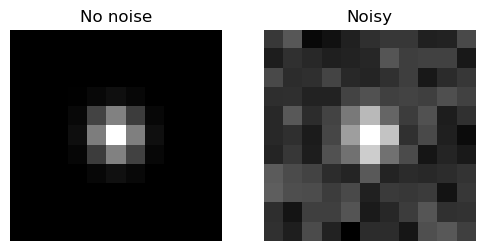

In [10]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,3))

ax1.imshow(videos[0][0], cmap='gray')
ax1.axis('off')
ax1.set_title('No noise')

ax2.imshow(videos2[0][0], cmap='gray')
ax2.axis('off')
ax2.set_title('Noisy')

plt.show()

## Trajectory visualization

### Anisotropic

In [17]:
np.random.seed(seed)

T = 300
props = generate_diffusion_props(N, image_props['D_min'], image_props['D_max'], image_props['angle_max'], is_isotropic=False)
p1, p2, theta = props[:,0], props[:,1], props[:,2]
    
# Create trajectories
disp = create_displacements(p1, p2, theta, N, T, dt=0.001)
pos = create_trajectories(p1, p2, theta, N, T, dt=0.001)

### Two-state

In [28]:
binding = True

np.random.seed(seed)

if not binding:
    props_0 = generate_diffusion_props(N, image_props['D_min'], image_props['D_max'], image_props['angle_max'], is_isotropic=True)
    props_1 = generate_diffusion_props(N, image_props['D_min'], image_props['D_max'], image_props['angle_max'], is_isotropic=True)
else:
    print("Creating a binding dataset")
    
    bind_min, bind_max = 0.005, 0.01
    n = N//2

    # First state
    bound_0 = generate_diffusion_props(n, bind_min, bind_max, image_props['angle_max'], is_isotropic=True, is_binding=True)
    unbound_0 = generate_diffusion_props(n, image_props['D_min'], image_props['D_max'], image_props['angle_max'], is_isotropic=False)

    # Second state
    unbound_1 = generate_diffusion_props(n, image_props['D_min'], image_props['D_max'], image_props['angle_max'], is_isotropic=False)
    bound_1 = generate_diffusion_props(n, bind_min, bind_max, image_props['angle_max'], is_isotropic=True, is_binding=True)

    props_0 = np.concatenate((bound_0, unbound_0), axis=0)
    props_1 = np.concatenate((unbound_1, bound_1), axis=0)

p1_0, p2_0, theta_0 = props_0[:, 0], props_0[:, 1], props_0[:, 2]
p1_1, p2_1, theta_1 = props_1[:, 0], props_1[:, 1], props_1[:, 2]

print(f"First state: {p1_0}, Second state: {p1_1}")

# Get random point to make transition between states
T_0 = np.random.randint(1, T, size=N)
print(f"Transition point: {T_0}")

# Make time-varying diffusion properties
p1 = np.zeros((N,T))
p2 = np.zeros_like(p1)
theta = np.zeros_like(p1)

for i in range(N):
    p1[i] = np.concatenate((
                np.tile(p1_0[i, None], (1, T_0[i])),
                np.tile(p1_1[i, None], (1, T - T_0[i]))
            ),
                axis=-1
        )
    p2[i] = np.concatenate((
                np.tile(p2_0[i, None], (1, T_0[i])),
                np.tile(p2_1[i, None], (1, T - T_0[i]))
            ),
                axis=-1
        )
    theta[i] = np.concatenate((
                np.tile(theta_0[i, None], (1, T_0[i])),
                np.tile(theta_1[i, None], (1, T - T_0[i]))
            ),
                axis=-1
        )
    
# Generate trajectories
pos = create_multi_state_trajectories(p1, p2, theta, N, T, dt=0.001)

Creating a binding dataset
First state: [0.00771702 3.4       ], Second state: [0.55       0.00835375]
Transition point: [ 15 291]


In [12]:
def plot_trajectories_item_color_coded(ax, trajectories, colors, N_PARTICLES_PLOTTED):
    starts = [] 
    for i in range(min(len(trajectories), N_PARTICLES_PLOTTED)):
        P = np.stack(trajectories[i])
        x, y = P[:,0], P[:,1]
        starts.append(P[0])
        ax.plot(x, y, color=colors[i], label=i)
    starts = np.vstack(starts)
    ax.scatter(starts[:,0], starts[:,1], s=6, facecolors='none', edgecolors='blue', linewidths=1.5)
    ax.set_title("Subtrajectories for frame generation")
    ax.set_xticks([])
    ax.set_yticks([])

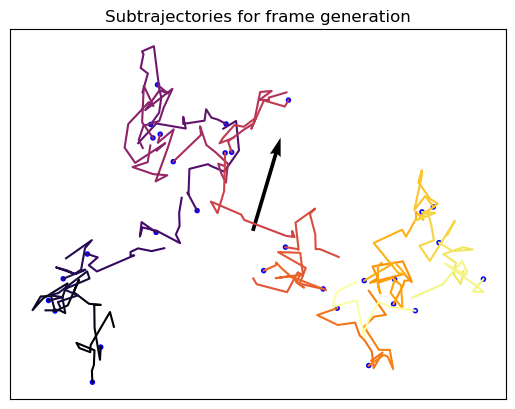

In [25]:
fig, ax = plt.subplots()

# Reshape the trajectories to get sub-segments
frames = pos[0].reshape(-1, nPosPerFrame, 2)

cmap = plt.colormaps['inferno'].resampled(T//nPosPerFrame)
colors = cmap(np.linspace(0, 1, T//nPosPerFrame)) 

plot_trajectories_item_color_coded(ax, frames, colors, T//nPosPerFrame)

x0, y0 = np.mean(frames, axis=(0,1))

ax.quiver(x0, y0, np.cos(theta[0]), np.sin(theta[0]),
           angles='xy', scale_units='xy', scale=5, label='Orientation')

# Legend for displaying frame number relative to cmap
# ax.legend(
#     ncol=2,
#     fontsize=8,
#     handlelength=1.5,
#     columnspacing=1.0,
#     labelspacing=0.3,
#     framealpha=0.3
# )

## Display for different noise levels

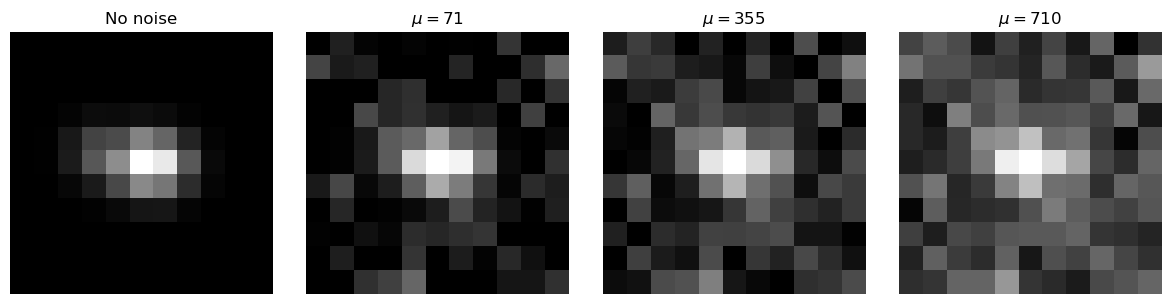

In [29]:
import matplotlib.pyplot as plt

image_props = SINGLE_STATE_PROPS

NOISE_LEVELS = [0, 1/20, 1/4, 1/2]

images = []
for i, noise in enumerate(NOISE_LEVELS):
    if i == 0:
        image_props['gaussian_noise'] = False
    else:
        image_props['gaussian_noise'] = True
    image_props['background_intensity'][0] = noise * background_mean
    
    # Genereate videos
    np.random.seed(2)
    videos, displacements, labels = create_training_set_w_features(1, T, image_props)
    
    images.append(videos[0][0])
    
fig, axes = plt.subplots(1, 4, figsize=(12, 3))

for i, (ax, img) in enumerate(zip(axes, images)):
    ax.imshow(img, cmap="gray")
    if i == 0:
        ax.set_title('No noise')
    else:
        ax.set_title(rf'$\mu = {int(NOISE_LEVELS[i] * background_mean)}$')
    ax.axis("off")

#fig.supxlabel('Background Gaussian Noise Variation ')
fig.tight_layout()
plt.show()

## Display for different PSF sizes

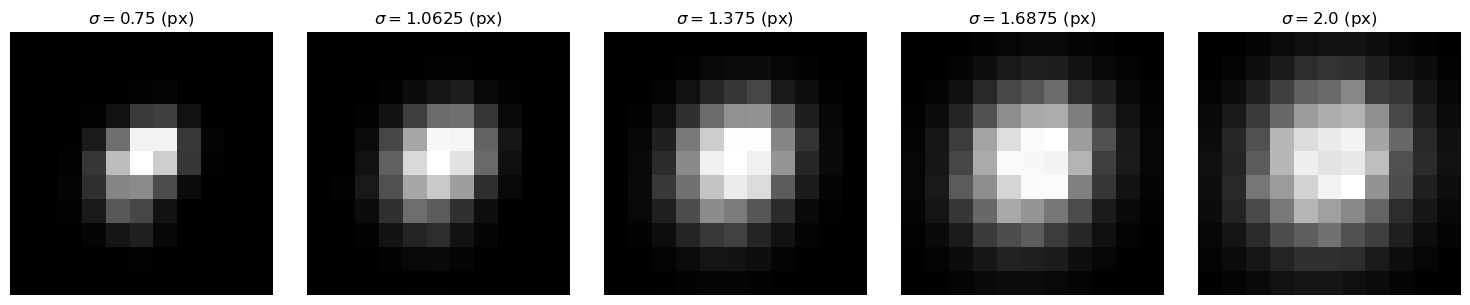

In [30]:
image_props = SINGLE_STATE_PROPS
image_props['gaussian_noise'] = False

# Choose sigmas and calculate required aperture
sigmas = np.linspace(0.75, 2, num=5)
apertures =  0.51 * image_props['wavelength'] / image_props['resolution'] / 2.355 / sigmas

images = []
for i, aperture in enumerate(apertures):
    # Update with new division factor (used for changing gaussian_sigma)  
    image_props['NA'] = aperture
    
    np.random.seed(1)
    videos, displacements, labels = create_training_set_w_features(1, T, image_props)
    
    images.append(videos[0][0])
    
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i, (ax, img) in enumerate(zip(axes, images)):
    ax.imshow(img, cmap="gray")
    ax.set_title(rf'$\sigma = {sigmas[i]}$ (px)')
    ax.axis("off")

#fig.supxlabel('PSF Size Variation ')
fig.tight_layout()
plt.show()

## Matrix of PSF sizes and noise

In [ ]:
image_props = SINGLE_STATE_PROPS
image_props['gaussian_noise'] = False

# Choose sigmas and calculate required aperture
sigmas = np.linspace(0.75, 2, num=3)
apertures =  0.51 * image_props['wavelength'] / image_props['resolution'] / 2.355 / sigmas
fwhm = 0.51 * image_props['wavelength'] / apertures * 1e9 #nm

NOISE_LEVELS = [0, 120, 310] # just set these values empircally to vary the SNR

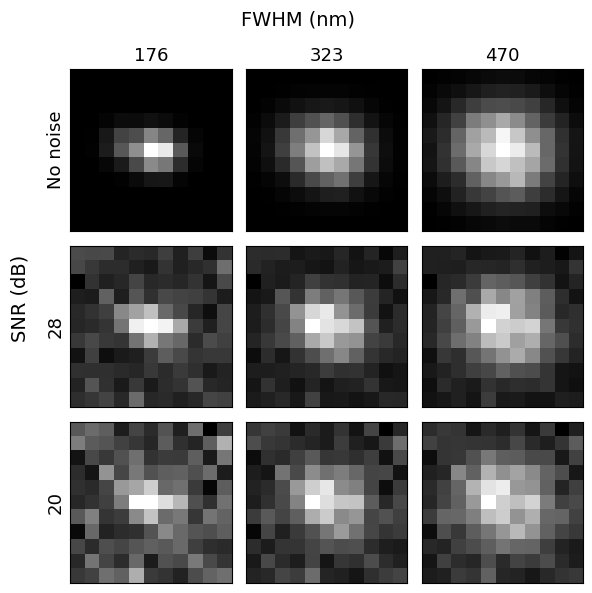

In [6]:
fig, axs = plt.subplots(3,3, figsize=(6,6))

# Loop for noise
for i in range(3):
    if i == 0:
        image_props['gaussian_noise'] = False
    else:
        image_props['gaussian_noise'] = True
        
    image_props['background_intensity'][1] = NOISE_LEVELS[i]      
    # Loop for psf
    for j in range(3):
        image_props['NA'] = apertures[j]
        
        np.random.seed(2)
        # This cell will through an error because by 
        videos, displacements, labels = create_training_set_w_features(1, T, image_props, normalize=False)
        
        if j == 0:
            if i == 0:
                axs[i,j].set_ylabel('No noise', fontsize=13)
            else:
                snr = 20 * np.log10((videos.max() -  background_mean)/ NOISE_LEVELS[i])
                axs[i,j].set_ylabel(f'{int(snr):d}', fontsize=13)
                
        if i == 0:
            axs[i,j].set_title(f'{int(fwhm[j])}', fontsize=13)
        
        axs[i,j].imshow(videos[0][0], cmap='gray')
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])

fig.supylabel('SNR (dB)', fontsize=14)
fig.suptitle('FWHM (nm)', fontsize=14)
fig.tight_layout()
plt.show()